#Training Data

We will use the 'zoo dataset' to create a decision tree model.

[Zoo dataset](http://archive.ics.uci.edu/ml/datasets/Zoo?ref=datanews.io) -- As described in the dataset information sheet:


In [1]:
# First, we'll download the zoo dataset to a local (temporary) folder
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data

--2024-08-02 13:07:41--  http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘zoo.data’

zoo.data                [ <=>                ]   4.03K  --.-KB/s    in 0s      

2024-08-02 13:07:41 (40.8 MB/s) - ‘zoo.data’ saved [4126]



In [ ]:
# We can also download and display the dataset's description:
# This command downloads the relevant file
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.names
# This command displays the file's contents
!cat zoo.names

## Data Ingestion

Here we'll "ingest" the data by importing it into [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html):

In [2]:
from IPython.display import display
import pandas as pd

# Because the data file doesn't have header names, we'll list them here
# You can find a description of the data file at http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.names
feature_names = ['animal name', 'hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'type']

# Import the "zoo" dataset
zoo = pd.read_csv('zoo.data', names = feature_names)

# Lets take a peek at the data
zoo.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [4]:
# Libraries
import numpy as np
# Matplotlib is a common plotting library
import matplotlib.pyplot as plt
# Seaborn is handy for creating beautiful plots
import seaborn as sns; sns.set()

# Feature Extraction

We'll now split up the data into features and labels. We will not do any special pre-processing to generate features, but you are of course welcome to experiment with engineering new features if you have an intuition for how it will improve your model performance.  

In [3]:
features = zoo.loc[:, 'hair':'catsize'] # Omit animal name
labels = zoo.loc[:, 'type']
labels_alpha = set(zoo.loc[:, 'animal name'])

# We then convert the feature and labels dataframes to
# numpy ndarrays, which can interface with the scikit-learn models
X = features.to_numpy()
y = labels.to_numpy()

# Data Interogation
I had a close look at the data to get familiar. First I looked at the matrices that we are going to feed to the classifier. I realized that there are 101 animals at the zoo. Because our model will have 16 variables at its disposal to classify the data, the data matrix has 16 columns.

In [5]:
# To help familiarize yourself with these matrices,
# have a look at their 'shapes' and understand why they are so.
print('X shape', X.shape)
print('y shape', y.shape)

X shape (101, 16)
y shape (101,)


By looking at the animal names, I also realized that there were 100 names for 101 animals so there must be two with the same name.

In [ ]:
print(len(zoo.loc[:, 'animal name']))
print(len(zoo.loc[:, 'animal name'].unique()))

101
100


Last, I printed a nested list of all the animals of each type. This gave me a good feel for how the animals were to be classified and what some of the useful parameters might be. I also found out that there were two frogs.

In [ ]:

all_typed = [(zoo.loc[:, 'animal name'][i], zoo.loc[:, 'type'][i])
  for i in range(len(zoo.loc[:, 'type']))]
for z in zoo.loc[:, 'type'].unique():
  print("Class {}".format(z))
  mask = zoo['type'] == z
  #print(mask)
  print(', '.join(zoo[mask].loc[:, 'animal name']))


Class 1
aardvark, antelope, bear, boar, buffalo, calf, cavy, cheetah, deer, dolphin, elephant, fruitbat, giraffe, girl, goat, gorilla, hamster, hare, leopard, lion, lynx, mink, mole, mongoose, opossum, oryx, platypus, polecat, pony, porpoise, puma, pussycat, raccoon, reindeer, seal, sealion, squirrel, vampire, vole, wallaby, wolf
Class 4
bass, carp, catfish, chub, dogfish, haddock, herring, pike, piranha, seahorse, sole, stingray, tuna
Class 2
chicken, crow, dove, duck, flamingo, gull, hawk, kiwi, lark, ostrich, parakeet, penguin, pheasant, rhea, skimmer, skua, sparrow, swan, vulture, wren
Class 7
clam, crab, crayfish, lobster, octopus, scorpion, seawasp, slug, starfish, worm
Class 6
flea, gnat, honeybee, housefly, ladybird, moth, termite, wasp
Class 5
frog, frog, newt, toad
Class 3
pitviper, seasnake, slowworm, tortoise, tuatara


# ML Algorithm and Model

I copied this code across from the examples section of the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for
`sklearn.tree.DecisionTreeClassifier`. At first, I just built my classifier and tested it using the iris dataset as per the documentation. After I had the classifier working, and I'd tested the validation, I modified the code to use the zoo dataset. I experimented with the different outcomes that result from using the `max_depth` parameter versus the `max_leaf_nodes`.

- `max_leaf_nodes` is like putting a cap on how many terminal leaves the tree can have. Think of each leaf as a final decision or outcome the tree can make. If you set this parameter, you're saying, “I don’t want more than X number of final decisions.” This helps in keeping the tree simpler by restricting how many different outcomes it can produce, which can prevent it from overfitting to the training data.

- `max_depth`, on the other hand, limits how deep the tree can grow. It’s like saying, “I don’t want the tree to have more than X levels of decisions from the root to the leaves.” This controls how many splits or decision points there are from the start to the end of the tree. By limiting the depth, you ensure the tree doesn’t become too detailed and start capturing noise or irrelevant patterns in the training data.

Setting `max_leaf_nodes = 6` for my classifier would force it to merge two of the smaller classes of animal.

In [6]:
from sklearn import tree
# from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

#iris = load_iris()
#X = iris.data
#y = iris.target


clf = DecisionTreeClassifier(
    max_depth=6,
    #max_leaf_nodes=7,
    random_state=0)



## Quality Metric and Model Tuning

I found this code ofor splitting the data into training/testing subsets in the [`test_train_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) documentation. I decided to use a third of the data for testing. The

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Training

In [9]:

clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, random_state=0)

Testing that the model can make predictions from the test data.

In [10]:
y_pred = clf.predict(X_test)
print(y_pred)

[5 4 4 1 1 1 2 4 1 1 7 1 2 7 4 6 1 7 2 4 2 5 1 2 1 1 1 2 4 5 4 5 5 1]


# Evaluation
I started by calculating accuracy, precision and recall.

In [11]:
from sklearn.metrics import precision_score, recall_score

# Calculate accuracy
accuracy = clf.score(X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Recall: {recall:.4f}')

Accuracy: 0.8529
Precision: 0.8392
Recall: 0.8529


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


According to Chat GPT:
> When evaluating a model, it's important to consider both accuracy and precision because they give us different insights into how well the model is performing.

>Accuracy measures how often the model gets the right prediction overall. So, if your model is 90% accurate, it means it got 90 out of 100 predictions correct. Accuracy is a good overall measure, but it can be misleading in certain situations, especially when dealing with imbalanced datasets where some classes are much more common than others.

>Precision, on the other hand, is more focused. It tells you how many of the predictions that the model made as positive (or the class of interest) are actually correct. For example, if your model says 10 emails are spam, but only 7 of them actually are spam, your precision would be 70%. Precision is crucial when the cost of false positives is high, like in medical diagnoses where misclassifying a healthy person as sick (false positive) could have serious consequences.


# Visualizing the model



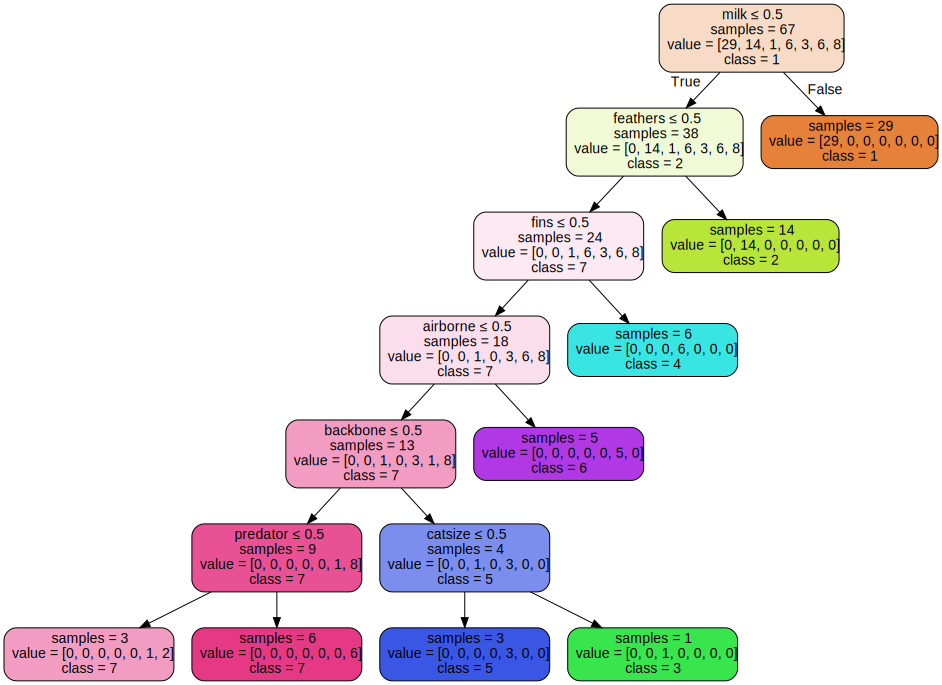

In [12]:
import graphviz

# clf = # YOUR DECISON TREE CLASSIFIER HERE
dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=features.columns,
                      class_names=sorted(list(map(str, labels.unique()))),
                      filled=True, rounded=True,
                      special_characters=True,
                      leaves_parallel = False,
                      impurity = False,
                      proportion=False)
graph = graphviz.Source(dot_data)
graph

In [13]:
for z in zoo.loc[:, 'type'].unique():
  print("Class {}".format(z))
  mask = zoo['type'] == z
  #print(mask)
  print(', '.join(zoo[mask].loc[:, 'animal name']))

Class 1
aardvark, antelope, bear, boar, buffalo, calf, cavy, cheetah, deer, dolphin, elephant, fruitbat, giraffe, girl, goat, gorilla, hamster, hare, leopard, lion, lynx, mink, mole, mongoose, opossum, oryx, platypus, polecat, pony, porpoise, puma, pussycat, raccoon, reindeer, seal, sealion, squirrel, vampire, vole, wallaby, wolf
Class 4
bass, carp, catfish, chub, dogfish, haddock, herring, pike, piranha, seahorse, sole, stingray, tuna
Class 2
chicken, crow, dove, duck, flamingo, gull, hawk, kiwi, lark, ostrich, parakeet, penguin, pheasant, rhea, skimmer, skua, sparrow, swan, vulture, wren
Class 7
clam, crab, crayfish, lobster, octopus, scorpion, seawasp, slug, starfish, worm
Class 6
flea, gnat, honeybee, housefly, ladybird, moth, termite, wasp
Class 5
frog, frog, newt, toad
Class 3
pitviper, seasnake, slowworm, tortoise, tuatara


# Feature Importance Evaluation

It seemed that the milk feature is the best classifier that allows the model to correctly classify almost half of the data in the first step. Milk is a feature unique to the mammals in the dataset. Looking at the list, our target "Type 1" is just mammals.

I decided to do a bit of feature abiation. By removing the milk column from the input data I assessed the impact on the model's performance and the structure of the resulting tree.

Without the milk column, the tree structure was a lot more complicated and, fiddling with the `max_depth` parameter, it seemed that the model now benefitted from more depth. The model didn't perform as well as it did with the milk even though it

Training Accuracy: 1.0000
Testing Accuracy: 0.9118
Precision: 0.9150
Recall: 0.9118


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


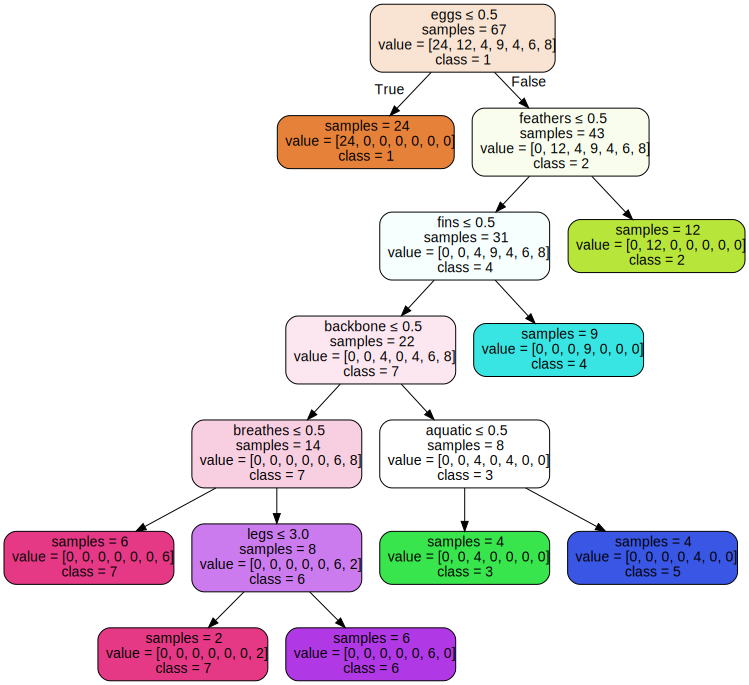

In [14]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import display
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score
import graphviz

# Because the data file doesn't have header names, we'll list them here
# You can find a description of the data file at
# http://archive.ics.uci.edu/ml/machine-learning-databases/zoo/zoo.names
feature_names = ['animal name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
                 'aquatic', 'predator', 'toothed', 'backbone', 'breathes',
                 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize',
                 'type']

# Import the "zoo" dataset
# zoo = pd.read_csv('zoo.data', names = feature_names)

zoo_no_milk = zoo.drop('milk', axis=1)

features2 = zoo_no_milk.loc[:, 'hair':'catsize'] # Omit animal name
labels2 = zoo_no_milk.loc[:, 'type']

X = features2.to_numpy()
y = labels2.to_numpy()

clf2 = DecisionTreeClassifier(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

###### Test

# Calculate accuracy, precision and recall
print(f"Training Accuracy: {clf2.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {clf2.score(X_test, y_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")

###### Visualize
graphviz.Source(tree.export_graphviz(clf2, out_file=None,
                      feature_names=features2.columns,
                      class_names=sorted(list(map(str, labels2.unique()))),
                      filled=True, rounded=True,
                      special_characters=True,
                      leaves_parallel = False,
                      impurity = False,
                      proportion=False)
  )

## Tuning
I performed k-fold cross-validation to evaluate the model’s performance across different max_depth values. I drew on [this explanation](https://scikit-learn.org/stable/modules/cross_validation.html) of cross-fold validation from the documentation.

![Cross-fold visualisation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


I won't keep testing data aside for post training evaluation. I want to see if the model can learn to have 100% accuracy for the zoo dataset. I plotted the mean accuracy for each max_depth value to analyze how the depth of the tree affects model performance.

I used ChatGPT wrote the bulk of the following code. I broke it and then Gemini helped me fix it.

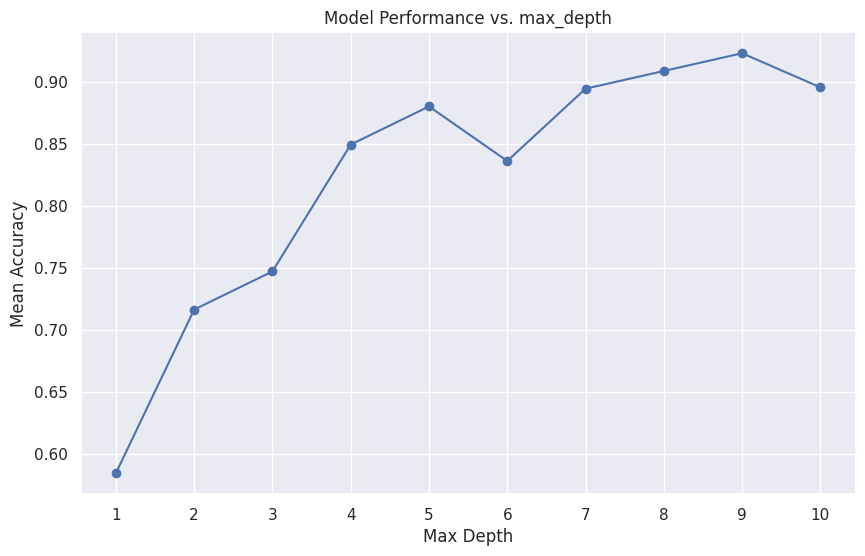

In [21]:
from sklearn.model_selection import cross_val_score, KFold

max_depth_values = np.arange(1, 11)  # Testing max_depth from 1 to 10

mean_scores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True)

for max_depth in max_depth_values:
    # Initialize the Decision Tree Classifier with the current max_depth
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

    # Perform cross-validation and compute the mean score
    results = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')
    #scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')

    mean_scores.append(results.mean())

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mean_scores, marker='o')
plt.title('Model Performance vs. max_depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

# Final Comments

I couldn't figure out a way to use K-fold cross validation to build a stronger decision tree. This surprised me as I expected that using more of the data to train the model would make it perform better. The models that I got from the CV process were only about as strong as the models where I set 30% of the data aside for testing.

The zoo dataset only contains 101 records, and all the records are unique. It seems like an excellent application for cross validation. Typically cross validation techniques are used in cases where data availability is marginal so that you don't have to sacrifice valuable data. This exercise is surely such a case as some of our target classes are represented by just 3 records. an unlucky 70/30 split would see all or most of the records of some target classes end up in the training data which would dramatically reduce the performance of the resulting model. I believe that is what drives the significant variance in performance that I have witnessed when re-running the final code block of this notebook.

# Acknowledgments
Thanks to the volunteers who do the thankless work of documenting open source projects. Thanks to Chat GPT and Gemini some help with the code in this notebook. Conversing with ChatGPT helped me to think this exercise through.